In [40]:
##################################
#                                #
# regression.ipynb               #
# Created 2023-07-26             #
# Akhil Garg, akhil@akhilgarg.ca #
#                                #
##################################

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import pickle
import os
import itertools

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn import metrics

import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [41]:
data = pd.read_excel('AMR_imputation_Dec_2023.xlsx')
original_columns = list(data)
data

,Anonymous_ID,Episode,AgeCat,Sex,YearOfAdmission,"Community(1), Hospital(2)",ICU Acquired,Medical(1) Surgical (2) Admitting Service,ClincalMRAS,ClinicalVRE,...,Daptomycin_PGNO_imp,Vancomycin_PGNO_imp,Linezolid_PGNO_imp,Amikacin_PGNO_imp,Tobramycin_PGNO_imp,Gentamicin_PGNO_imp,Clindamycin_PGNO_imp,Doxycycline_PGNO_imp,Erythromycin_PGNO_imp,TMPSMX_PGNO_imp
0,1,1,85-90,M,2008,2,0,1,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
1,1,2,85-90,M,2008,2,0,1,0,0,...,RESISTANT,no_data,RESISTANT,no_data,SUSCEPTIBLE,SUSCEPTIBLE,RESISTANT,no_data,RESISTANT,SUSCEPTIBLE
2,2,9,>90,M,2011,2,0,1,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
3,3,15,>90,M,2012,2,0,1,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
4,4,25,45-50,F,2013,2,0,1,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5766,4357,13584,70-75,F,2021,1,0,1,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
5767,4358,13585,70-75,M,2021,1,0,1,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
5768,4359,13586,>90,F,2021,1,0,1,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
5769,4360,13587,80-85,M,2021,1,0,1,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable


In [42]:
# Only keep data prior to a change in the micro lab reporting system
data2019 = data[data['Episode'] <= 7217]

# Remove data from before 2016 as it might contain outliers
data2019 = data2019[data2019['YearOfAdmission']>=2016]

# List of output antibiotics
output_antibiotics = ['Penicillin_FINAL_imp','Amoxiclav_FINAL_imp','Ampicillin_FINAL_imp','Cloxacillin_FINAL_imp','Piptaz_FINAL_imp','Cefazolin_FINAL_imp','Ceftriaxone_FINAL_imp','Ceftazidime_FINAL_imp','Ertapenem_FINAL_imp','Meropenem_FINAL_imp','Ciprofloxacin_FINAL_imp','Levofloxacin_FINAL_imp','Moxifloxacin_FINAL_imp','Daptomycin_FINAL_imp','Vancomycin_FINAL_imp','Linezolid_FINAL_imp','Amikacin_FINAL_imp','Tobramycin_FINAL_imp','Gentamicin_FINAL_imp','Clindamycin_FINAL_imp','Doxycycline_FINAL_imp','Erythromycin_FINAL_imp','TMPSMX_FINAL_imp']

# Missingness susceptibilities for each antibiotic
print('Missingness')
for abx in output_antibiotics:
    missingness = data2019[data2019[abx]=='no_data'].shape[0] / data2019.shape[0]
    print('{:<15} {:>6.2f}%'.format(abx.split('_')[0],missingness*100))
    
# Piperacillin-tazobactam or tobramycin missingness
print('{:<15} {:>6.2f}%'.format('Piptaz or tobra',
      data2019[(data2019['Piptaz_FINAL_imp']=='no_data')|(data2019['Tobramycin_FINAL_imp']=='no_data')].shape[0]/data2019.shape[0]*100))

Missingness
Penicillin        2.44%
Amoxiclav        35.31%
Ampicillin        1.02%
Cloxacillin       6.58%
Piptaz            1.26%
Cefazolin         1.46%
Ceftriaxone       0.51%
Ceftazidime       0.85%
Ertapenem         1.59%
Meropenem         0.51%
Ciprofloxacin     1.32%
Levofloxacin     16.62%
Moxifloxacin      4.65%
Daptomycin        1.87%
Vancomycin        1.87%
Linezolid         1.87%
Amikacin          2.20%
Tobramycin        0.64%
Gentamicin        0.61%
Clindamycin       4.41%
Doxycycline      80.94%
Erythromycin     55.33%
TMPSMX            0.58%
Piptaz or tobra   1.36%


## Preprocessing

In [43]:
# Add a column for hospital site 
data2019['hosp_Sunnybrook'] = 1
data2019['hosp_TOH'] = 0
data2019['hosp_Trillium'] = 0

In [44]:
# Change missing data to be resistant
data2019[output_antibiotics] = data2019[output_antibiotics].replace('no_data','RESISTANT')

# Convert susceptible/intermediate/resistant to numerical categorical values
data2019 = data2019.replace({'SUSCEPTIBLE':0,'INTERMEDIATE':1,'RESISTANT':1})

# Convert age to a continuous variable
age_categories = {'<40'  :30, 
                  '40-45':42.5,
                  '45-50':47.5,
                  '50-55':52.5,
                  '55-60':57.5,
                  '60-65':62.5,
                  '65-70':67.5,
                  '70-75':72.5,
                  '75-80':77.5,
                  '80-85':82.5,
                  '85-90':87.5,
                  '>90'  :95
                 }
data2019['Age'] = data2019['AgeCat'].replace(age_categories)

# Standard scale age
age_StandardScaler = preprocessing.StandardScaler().fit(data2019[['Age']])
data2019['age_scaled'] = age_StandardScaler.transform(data2019[['Age']])

# Save age scaler file to pickle for later use
# with open('age_scaler.pickle','wb') as scaler_file:
#     pickle.dump(age_StandardScaler,scaler_file)

# Create a column for location of acquisition: community (1), ward (2), ICU (3)
# Created by summing Comm (1) vs. Hosp (2) and ICU acquisition (0 or 1)
data2019['Acquisition'] = data2019['Community(1), Hospital(2)'] + data2019['ICU Acquired']
data2019['Acquisition'] = data2019['Acquisition'].replace({1:'community',2:'ward',3:'ICU'})

# Change medical vs. surgical admitting service from numbers to words
data2019['Medical(1) Surgical (2) Admitting Service'] = data2019['Medical(1) Surgical (2) Admitting Service'].replace({1:'medical',2:'surgical'})

# One hot encode categories
one_hot_data = pd.get_dummies(data2019, columns=['Sex','Acquisition','Medical(1) Surgical (2) Admitting Service'],
                                        prefix= ['sex','acquisition','adm_service'])

### Encode prior antibiotic exposure

In [45]:
# Create a column of prior exposure to either penicillins or aminoglycosides
conditions = [((one_hot_data['PriorPenicillin']==0) & (one_hot_data['PriorAMG']==0)),
              ((one_hot_data['PriorPenicillin']==1) | (one_hot_data['PriorAMG']==1))]
# default -1 value should not occur, and is an error-checking mechanism
one_hot_data['PriorPenicillin_or_AMG'] = np.select(conditions, [0,1], default=-1)

# Create new categories of "prior non-[antibiotic class]"
one_hot_data['PriorNonCephalosporin'] = one_hot_data[['PriorAMG','PriorCarbapenem','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
one_hot_data['PriorNonCarbapenem'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
one_hot_data['PriorNonPenicillin'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonFQ'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonAMG'] = one_hot_data[['PriorFQ','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonOtherAbx'] = one_hot_data[['PriorFQ','PriorAMG','PriorCephalosporin','PriorPenicillin','PriorCarbapenem']].any(axis='columns')

one_hot_data['PriorNonPenicillin_or_AMG'] = one_hot_data[['PriorFQ','PriorCephalosporin','PriorCarbapenem']].any(axis='columns')

one_hot_data

,Anonymous_ID,Episode,AgeCat,YearOfAdmission,"Community(1), Hospital(2)",ICU Acquired,ClincalMRAS,ClinicalVRE,ClinicalESBL,RecentHospitalization,...,adm_service_medical,adm_service_surgical,PriorPenicillin_or_AMG,PriorNonCephalosporin,PriorNonCarbapenem,PriorNonPenicillin,PriorNonFQ,PriorNonAMG,PriorNonOtherAbx,PriorNonPenicillin_or_AMG
28,24,130,>90,2016,2,0,1,0,0,0,...,True,False,0,True,True,True,True,True,True,True
29,25,131,>90,2016,2,0,0,0,0,0,...,True,False,0,False,False,False,False,False,False,False
30,26,144,80-85,2016,2,0,0,0,0,0,...,False,True,0,True,True,True,True,True,True,True
31,26,145,80-85,2016,2,0,0,0,0,0,...,False,True,0,True,True,True,True,True,True,True
32,27,149,>90,2016,2,0,0,0,0,0,...,True,False,0,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,2313,7212,60-65,2019,1,0,0,0,0,0,...,True,False,0,False,False,False,False,False,False,False
2972,2314,7215,75-80,2019,2,0,0,0,0,1,...,True,False,0,False,False,False,False,False,False,False
2973,2314,7215,75-80,2019,2,0,0,0,0,1,...,True,False,0,False,False,False,False,False,False,False
2974,2314,7216,75-80,2019,2,1,0,0,0,1,...,True,False,1,True,True,True,True,True,True,True


### List of antibiotics and classes to run regression on


In [46]:
antibiotic_list = ['Cefazolin','Ceftriaxone','Ceftazidime','Piptaz','Meropenem','Ciprofloxacin','Tobramycin','TMPSMX']

# New antibiotic list as of 2024-03-26:
antibiotic_list = ['Meropenem','Piptaz','Ceftazidime','Ceftriaxone','Ciprofloxacin']

antibiotic_classes = {'Cefazolin':'Cephalosporin','Ceftriaxone':'Cephalosporin','Ceftazidime':'Cephalosporin',
                      'Piptaz':'Penicillin','Meropenem':'Carbapenem','Ciprofloxacin':'FQ','Tobramycin':'AMG',
                      'TMPSMX':'OtherAbx','Piptaz_or_Tobramycin':'Penicillin_or_AMG'}

In [47]:
# Add a column for combined pip-taz and tobramycin via multiplication    
# (would only be 1 (resistant) if both are 1 (resistant), otherwise 0 (susceptible))
one_hot_data['Piptaz_or_Tobramycin_FINAL_imp'] = (one_hot_data['Piptaz_FINAL_imp'])*(one_hot_data['Tobramycin_FINAL_imp'])

### Handling previous antibiotic exposure and resistance

In [48]:
# Look for antibiotic resistance during previous gram negative infection
def previous_infection(priorGNOrg,prior_susceptibility):
    '''
    For a given antibiotic, takes a previous gram negative organism and its susceptibility as input
    Outputs:
        0 if no previous gram negative organism
        0 if previous gram negative organism without susceptibility data
        1 if previous susceptible gram negative organism
        2 if previous resistant gram negative organism 
    '''
    
    if priorGNOrg=='not_applicable': return 0
    elif prior_susceptibility=='no_data': return 0

    # 0 = prior susceptible, 1 = prior resistant
    elif (priorGNOrg!='not_applicable') and (prior_susceptibility==0): return 1
    elif (priorGNOrg!='not_applicable') and (prior_susceptibility==1): return 2
        
    else: raise ValueError('Inputs passed to the previous_infection function are invalid.')

# Add a column for previous susceptibility to the particular antibiotic
for antibiotic in antibiotic_list:
    one_hot_data[antibiotic+'Resistance'] = one_hot_data.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)

In [49]:
# Special case of piperacillin-tazobactam plus tobramycin

    # 0 if no previous gram negative organism
    # 0 if previous gram negative organism without susceptibility data for either antibiotic
    # 1 if previous resistance to only one of the two antibiotics (the other may be susceptible or have no data)
    # 2 if previous resistance to both antibiotics

# Note that this behaviour is slightly different from the function for single antibiotic susceptibility histories,
    # which would assign a 1 if the previous antibiotic was susceptible

# 0 = prior susceptible, 1 = prior resistant
conditions = [(one_hot_data['PriorGNOrg']=='not_applicable'),              
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']==0)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']==0)),  
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']==1)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']==0)),
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']==1)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']==1))]
values = [0,0,0,0,0,1,1,1,1,2]
# default -1 value should not occur, and is an error-checking mechanism
one_hot_data['Piptaz_or_TobramycinResistance'] = np.select(conditions, values, default=-1)

# if 'Piptaz_or_Tobramycin' not in antibiotic_list:
#     antibiotic_list.append('Piptaz_or_Tobramycin')

In [50]:
# Convert prior resistance history into one-hot encoding

for antibiotic in antibiotic_list:
    one_hot_data[antibiotic+'Resistance'] = one_hot_data[antibiotic+'Resistance'].replace({0:'no_prior',
                                                                                           1:'susceptible',
                                                                                           2:'nonsusceptible'
                                                                                          })
    one_hot_data = pd.get_dummies(one_hot_data,columns=[antibiotic+'Resistance'])

In [51]:
# List of categories regression could be run on
list(one_hot_data)

['Anonymous_ID',
 'Episode',
 'AgeCat',
 'YearOfAdmission',
 'Community(1), Hospital(2)',
 'ICU Acquired',
 'ClincalMRAS',
 'ClinicalVRE',
 'ClinicalESBL',
 'RecentHospitalization',
 'ICUExposure',
 'culture_test_cd',
 'PriorPenicillin',
 'PriorCephalosporin',
 'PriorCarbapenem',
 'PriorAMG',
 'PriorFQ',
 'PriorOtherAbx',
 'FINAL',
 'Penicillin_FINAL_imp',
 'Amoxiclav_FINAL_imp',
 'Ampicillin_FINAL_imp',
 'Cloxacillin_FINAL_imp',
 'Piptaz_FINAL_imp',
 'Cefazolin_FINAL_imp',
 'Ceftriaxone_FINAL_imp',
 'Ceftazidime_FINAL_imp',
 'Ertapenem_FINAL_imp',
 'Meropenem_FINAL_imp',
 'Ciprofloxacin_FINAL_imp',
 'Levofloxacin_FINAL_imp',
 'Moxifloxacin_FINAL_imp',
 'Daptomycin_FINAL_imp',
 'Vancomycin_FINAL_imp',
 'Linezolid_FINAL_imp',
 'Amikacin_FINAL_imp',
 'Tobramycin_FINAL_imp',
 'Gentamicin_FINAL_imp',
 'Clindamycin_FINAL_imp',
 'Doxycycline_FINAL_imp',
 'Erythromycin_FINAL_imp',
 'TMPSMX_FINAL_imp',
 'PriorGNOrg',
 'Penicillin_PGNO_imp',
 'Amoxiclav_PGNO_imp',
 'Ampicillin_PGNO_imp',
 'Clox

### Organisms isolated

In [52]:
one_hot_data['FINAL'].value_counts()

FINAL
Escherichia coli                                 1397
Klebsiella pneumoniae                             445
Pseudomonas aeruginosa                            418
Enterobacter cloacae                              138
Proteus mirabilis                                 129
Serratia marcescens                                64
Enterobacter aerogenes                             61
Klebsiella oxytoca                                 59
Citrobacter koseri                                 57
Citrobacter freundii                               37
Morganella morganii                                25
Stenotrophomonas maltophilia                       22
Acinetobacter baumannii                            14
Haemophilus influenzae                             12
Proteus penneri                                     8
Providencia stuartii                                7
Raoultella                                          7
Klebsiella species                                  5
Providencia rettgeri  

# Regression Function

In [53]:
regression_inputs = ['Age','sex_M',
                     'acquisition_ICU','acquisition_ward',
                     'adm_service_surgical',
                     'RecentHospitalization',
                     
                     'Prior[Class]Exposure','Prior[NonClass]Exposure',
                     '[Antibiotic]_susceptible','[Antibiotic]_nonsusceptible',
                     
                     'ClinicalESBL']

print('Number of regression inputs: {}'.format(len(regression_inputs)))

Number of regression inputs: 11



Logistic regression model for Meropenem:

Logistic Regression Coefficients
PriorCarbapenem                             2.2724
MeropenemResistance_nonsusceptible          1.1543
ClinicalESBL                                0.7317
acquisition_ICU                             0.5450
sex_M                                       0.2250
PriorNonCarbapenem                          0.1839
acquisition_ward                            0.1178
Age                                        -0.0266
adm_service_surgical                       -0.5389
RecentHospitalization                      -0.5561
MeropenemResistance_susceptible            -1.2611

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.49
                     median:  0.98
                     mean:    0.96
                     max:     1.00
                     
Resistant isolates   min:     0.41
                     median:  0.92
                     mean:    0.82
                     max:     1.00
          

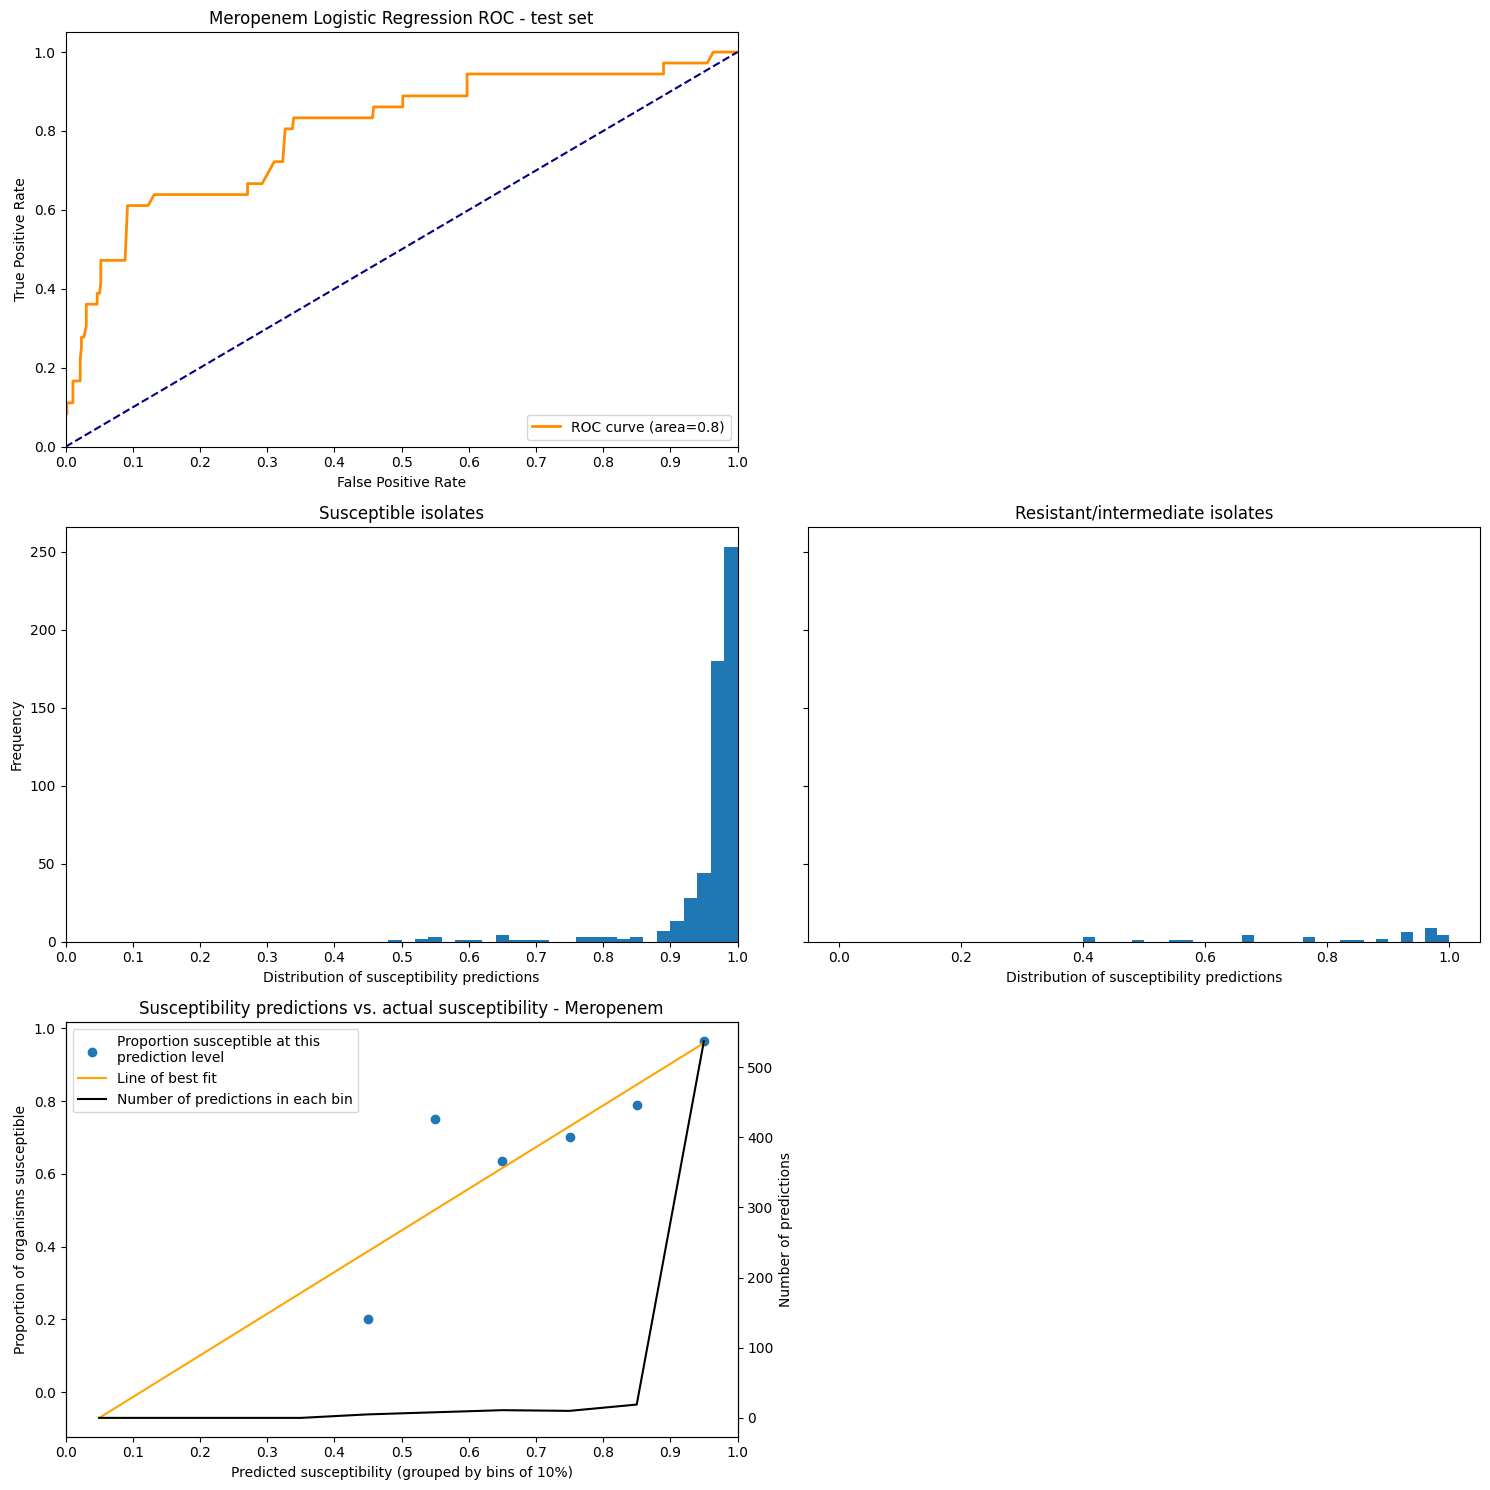


Logistic regression model for Piptaz:

Logistic Regression Coefficients
PiptazResistance_nonsusceptible             6.6949
ClinicalESBL                                1.8405
PriorNonPenicillin                          0.6407
PriorPenicillin                             0.3999
acquisition_ICU                             0.1665
adm_service_surgical                        0.1573
acquisition_ward                           -0.0046
Age                                        -0.0079
sex_M                                      -0.0108
RecentHospitalization                      -0.1051
PiptazResistance_susceptible               -0.6889

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.24
                     median:  0.85
                     mean:    0.80
                     max:     0.94
                     
Resistant isolates   min:     0.17
                     median:  0.71
                     mean:    0.68
                     max:     0.91
             

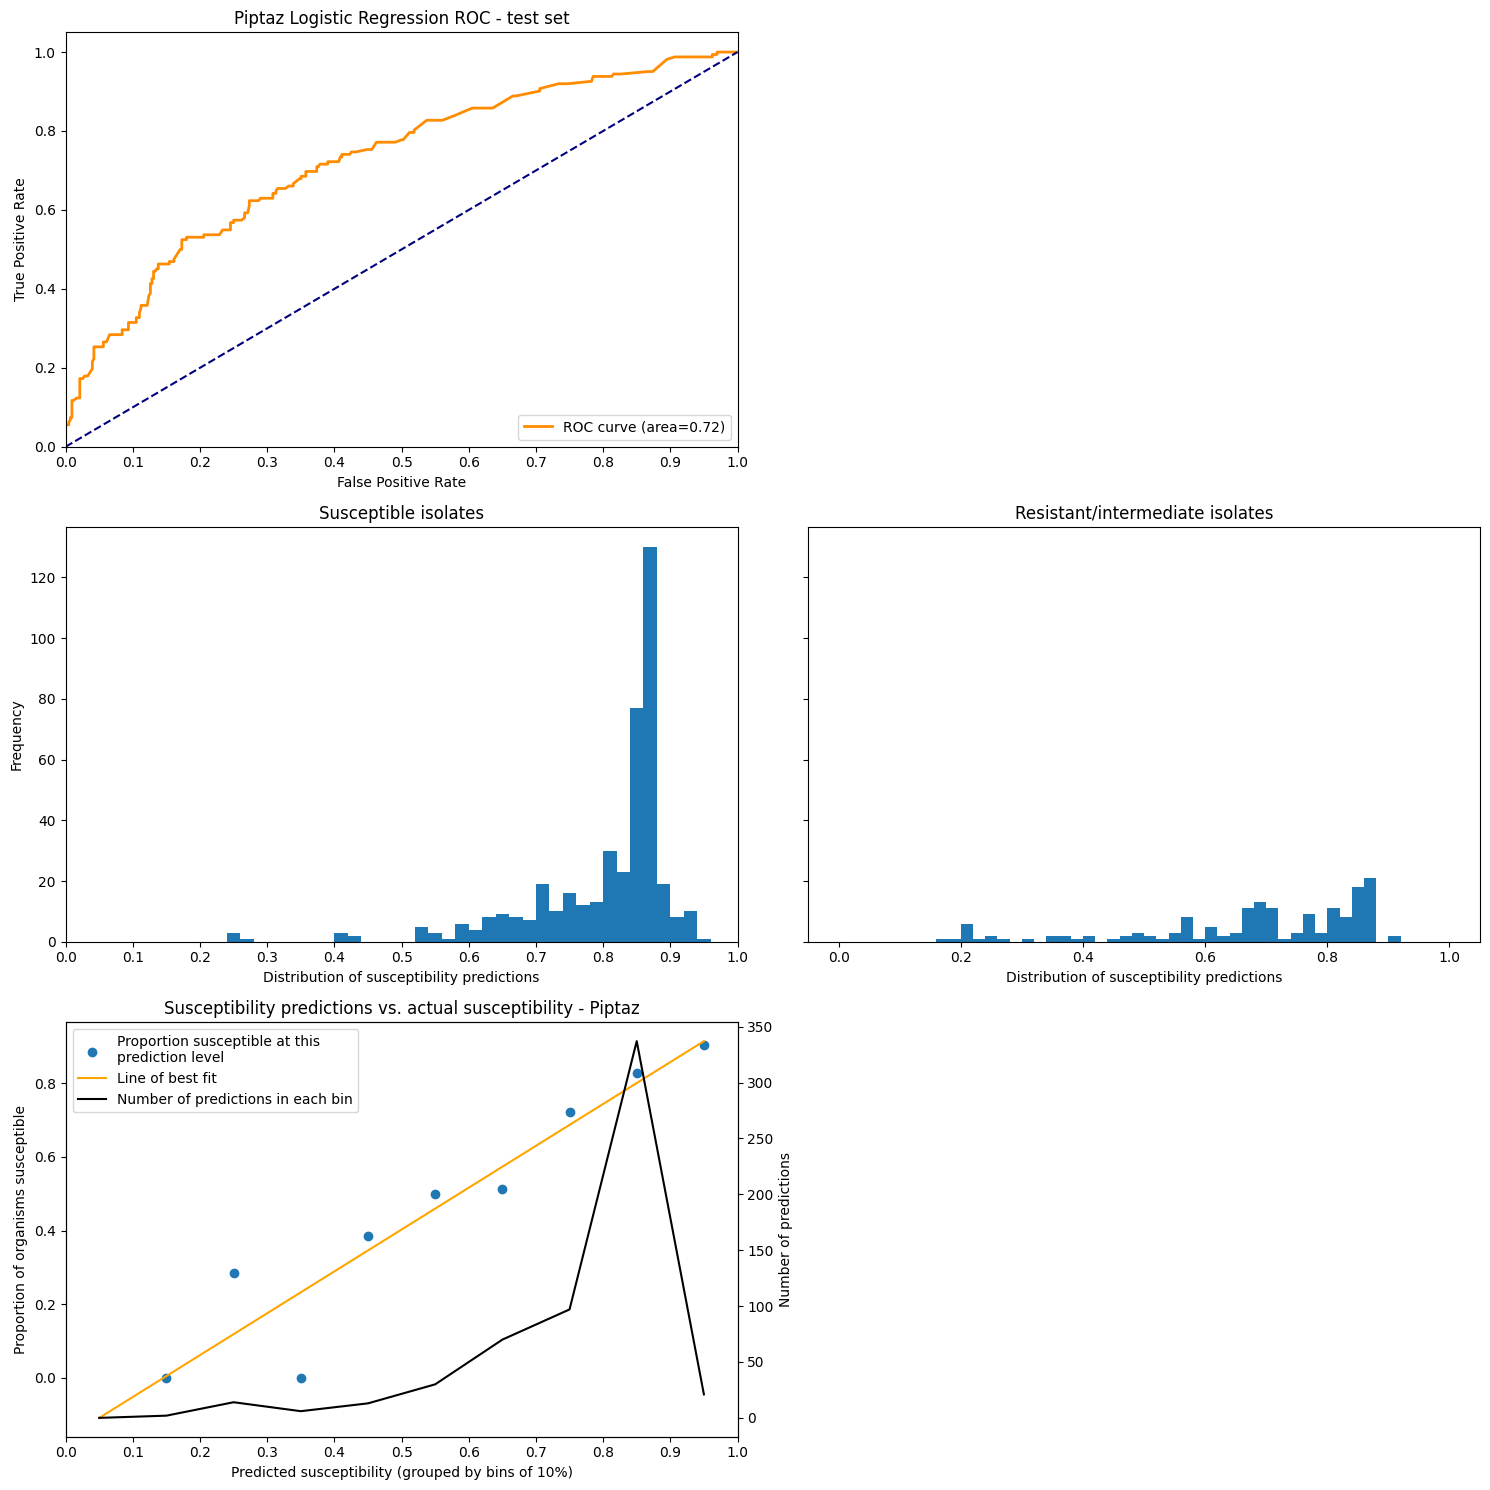


Logistic regression model for Ceftazidime:

Logistic Regression Coefficients
ClinicalESBL                                2.1223
CeftazidimeResistance_nonsusceptible        1.8091
PriorCephalosporin                          0.4086
acquisition_ICU                             0.3814
PriorNonCephalosporin                       0.3811
acquisition_ward                            0.1239
adm_service_surgical                        0.1008
RecentHospitalization                       0.0899
Age                                        -0.0068
sex_M                                      -0.1061
CeftazidimeResistance_susceptible          -0.9523

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.22
                     median:  0.88
                     mean:    0.84
                     max:     0.96
                     
Resistant isolates   min:     0.20
                     median:  0.78
                     mean:    0.73
                     max:     0.95
        

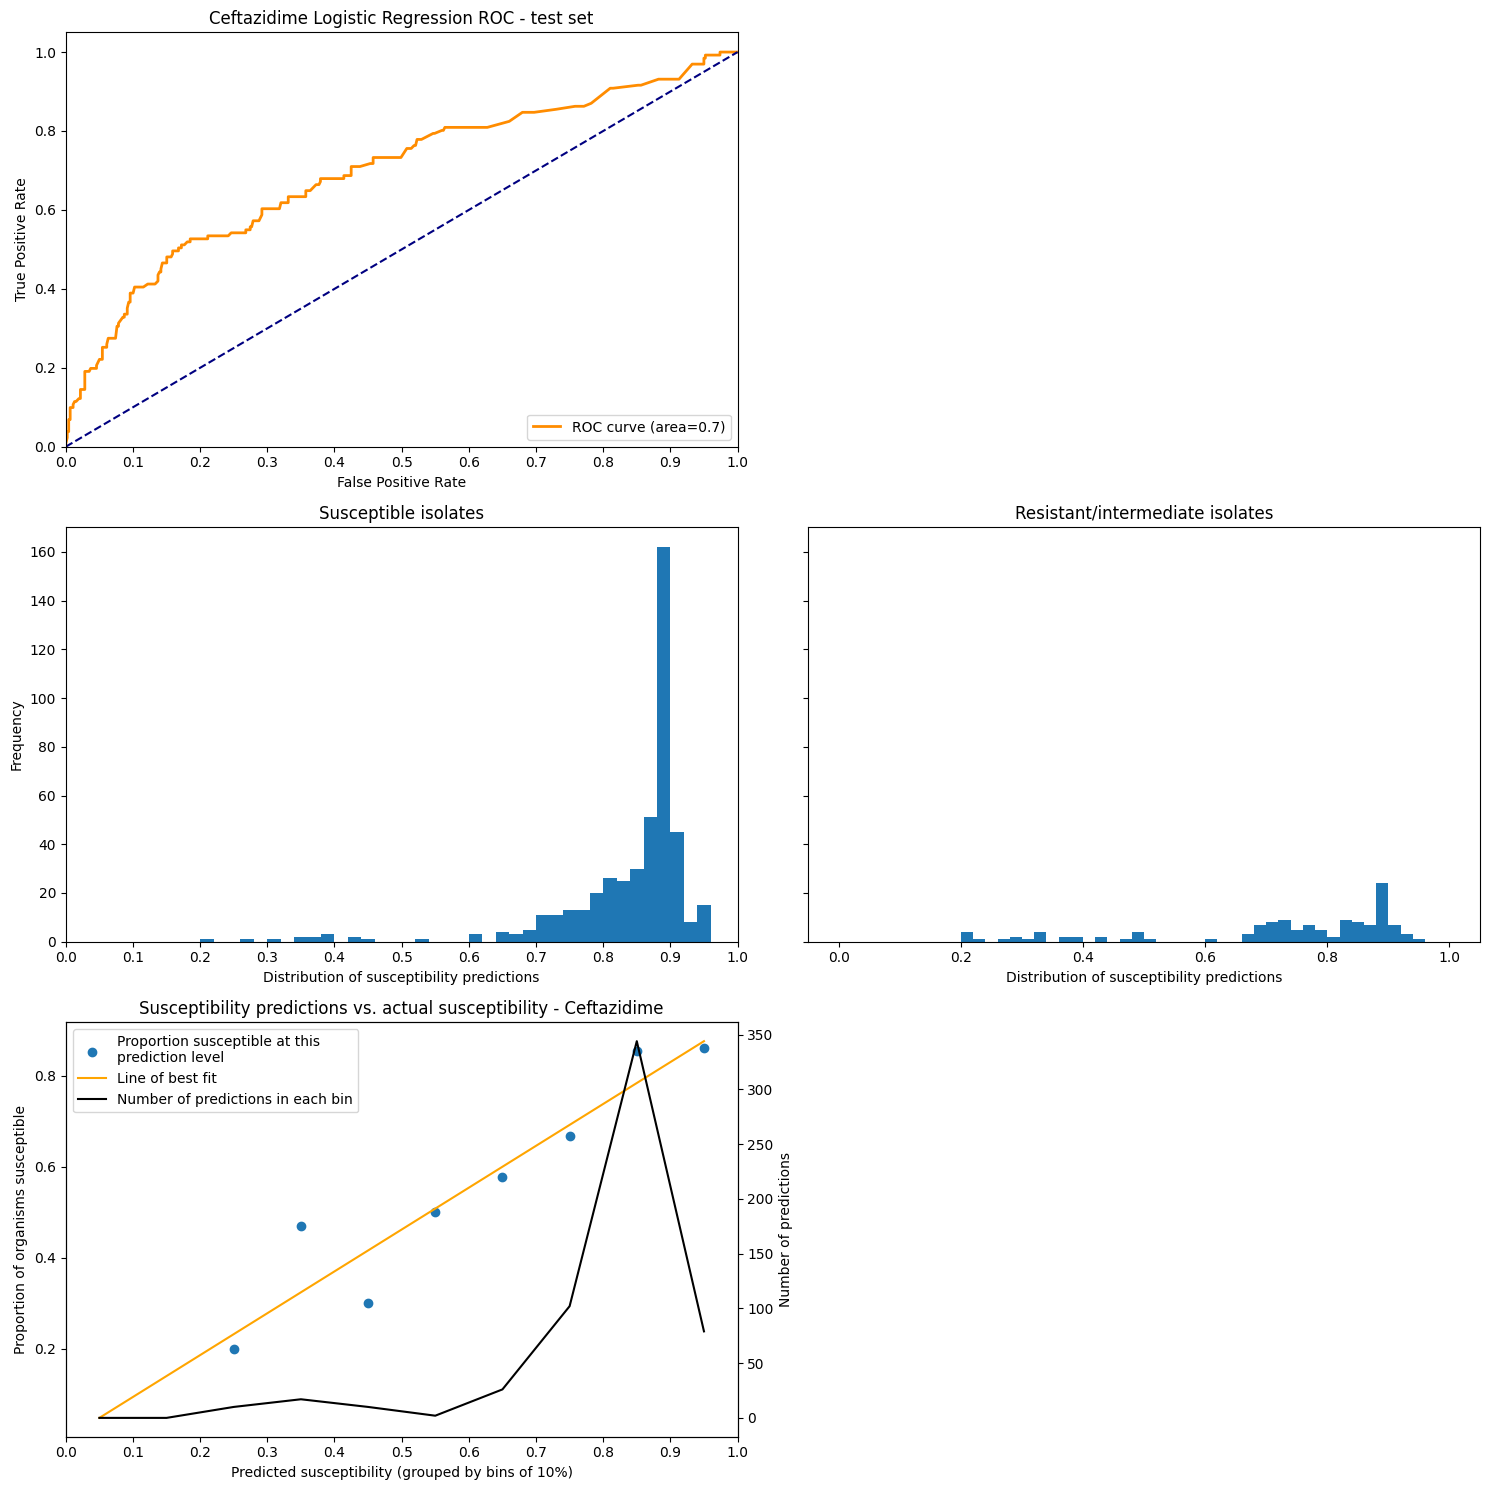


Logistic regression model for Ceftriaxone:

Logistic Regression Coefficients
ClinicalESBL                                1.9419
CeftriaxoneResistance_nonsusceptible        1.8269
PriorCephalosporin                          0.6206
acquisition_ICU                             0.6026
PriorNonCephalosporin                       0.2329
sex_M                                       0.1377
acquisition_ward                            0.1079
adm_service_surgical                        0.0910
RecentHospitalization                       0.0321
Age                                        -0.0100
CeftriaxoneResistance_susceptible          -0.6534

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.08
                     median:  0.81
                     mean:    0.76
                     max:     0.92
                     
Resistant isolates   min:     0.05
                     median:  0.63
                     mean:    0.58
                     max:     0.88
        

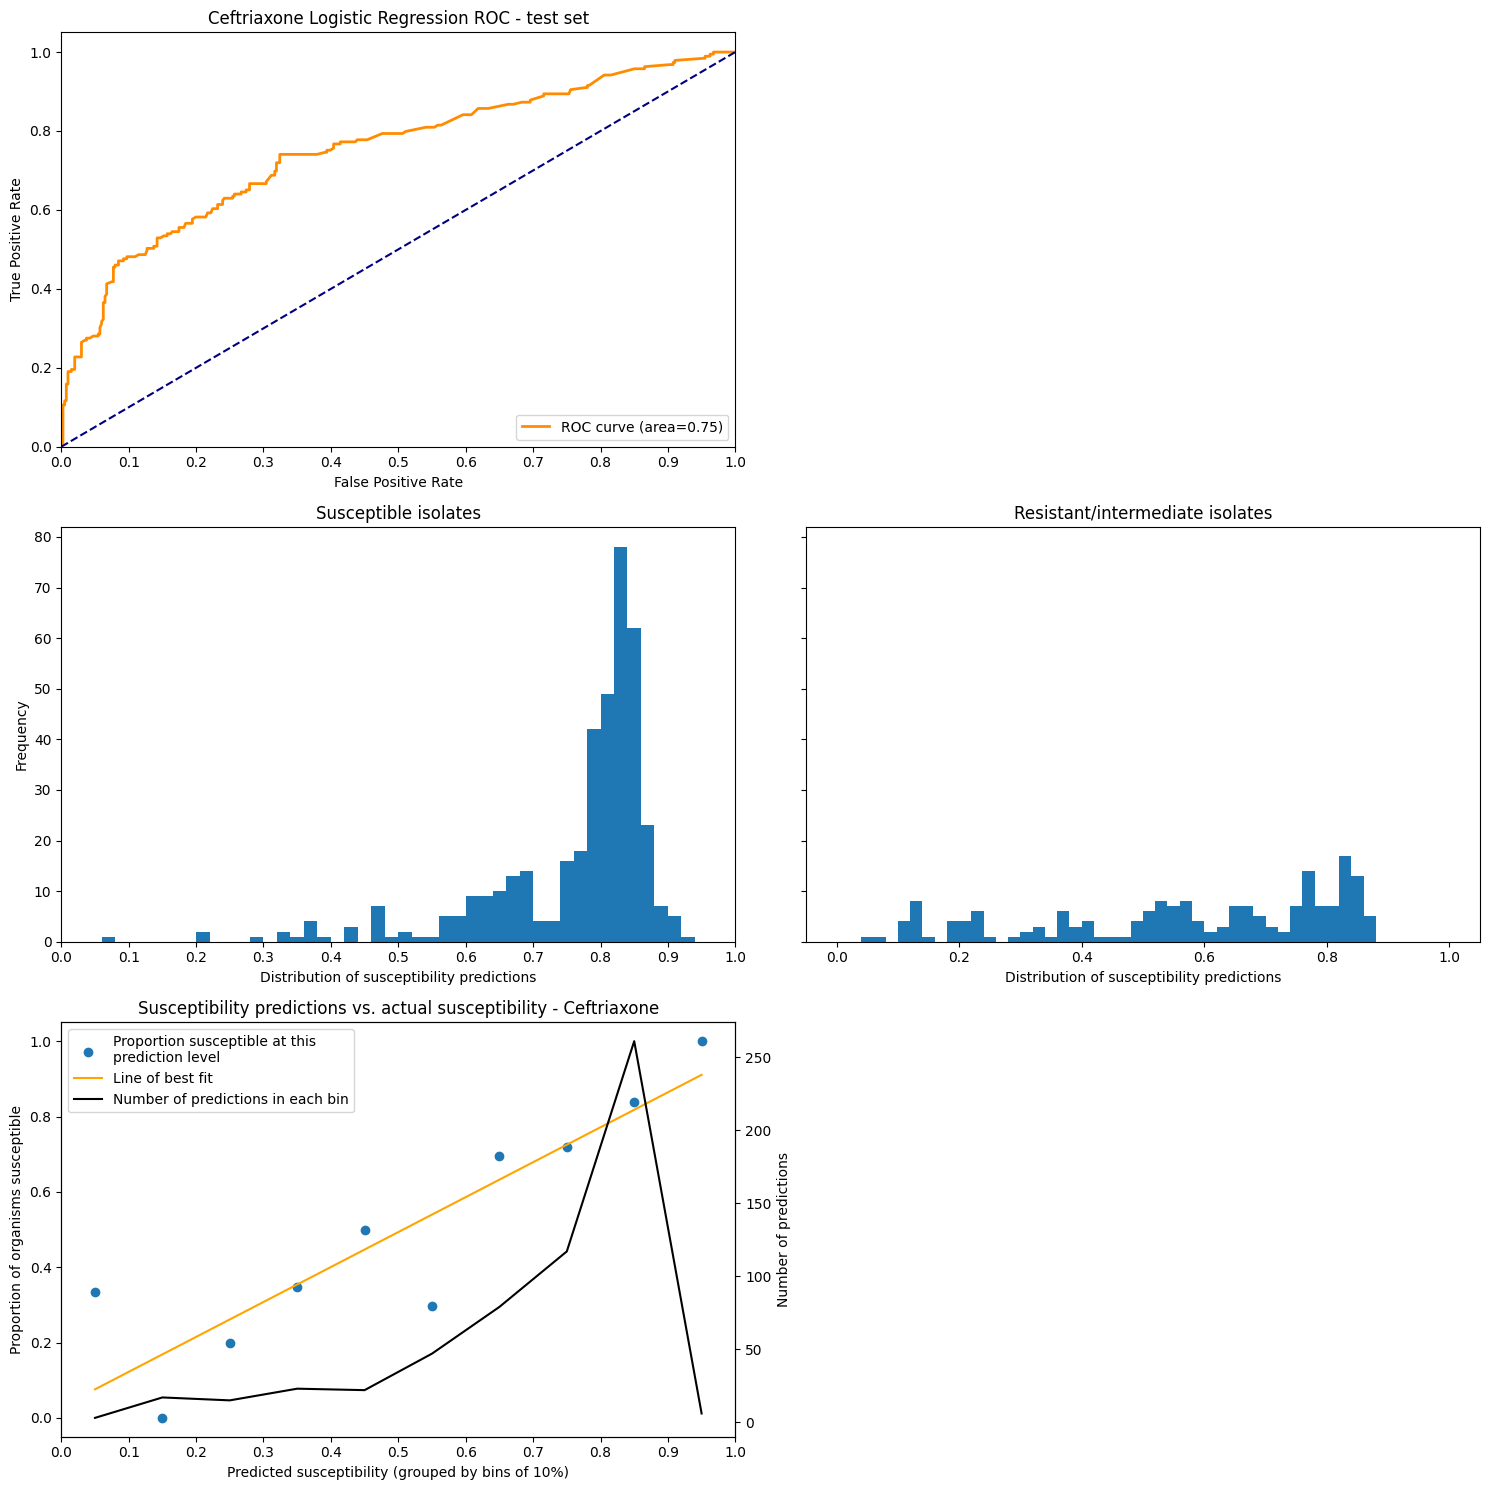


Logistic regression model for Ciprofloxacin:

Logistic Regression Coefficients
CiprofloxacinResistance_nonsusceptible      1.6901
PriorFQ                                     1.0703
ClinicalESBL                                1.0374
sex_M                                       0.3596
acquisition_ward                            0.0974
Age                                        -0.0042
RecentHospitalization                      -0.0155
adm_service_surgical                       -0.2161
acquisition_ICU                            -0.2534
CiprofloxacinResistance_susceptible        -0.2793
PriorNonFQ                                 -0.4475

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.30
                     median:  0.83
                     mean:    0.82
                     max:     0.94
                     
Resistant isolates   min:     0.08
                     median:  0.77
                     mean:    0.67
                     max:     0.91
      

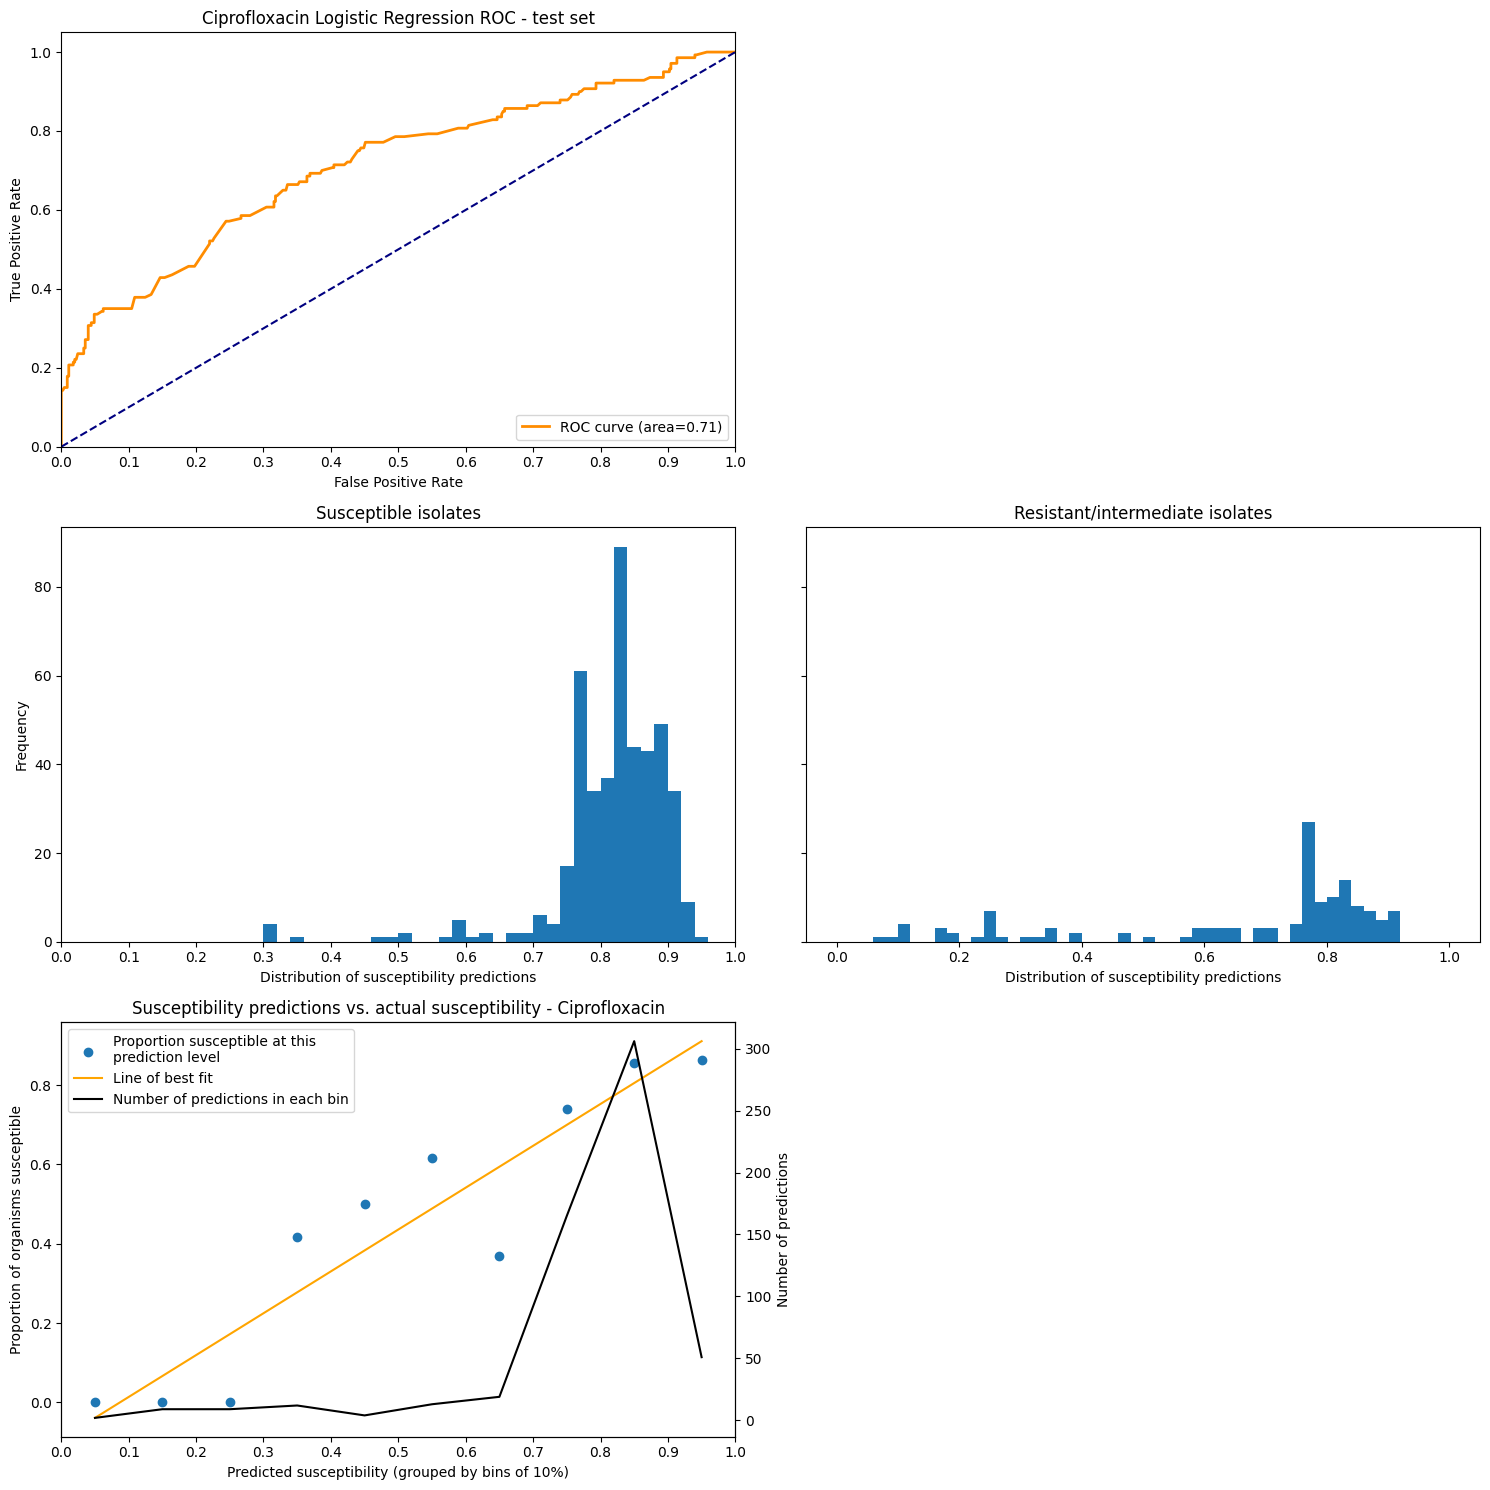

In [54]:
# Divide data into temporal 80-20 train-test sets
train_set, test_set= np.split(one_hot_data, [int(.8 *len(one_hot_data))])

# Collect a list of AUCs of the receiver operating characteristic
AUCROCs = []

for antibiotic in antibiotic_list:
    
    print('\nLogistic regression model for {}:\n'.format(antibiotic))
    
    regression_inputs = ['Age','sex_M',                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical','RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL'
                        ]
    
    # 0 = susceptible, 1 = resistant
    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']
    
    reg = linear_model.LogisticRegression(max_iter=500,penalty=None)
    reg.fit(X_train,Y_train)
    
    # Coefficients sorted by size
    print('Logistic Regression Coefficients')
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<42} {: .4f}'.format(i[1],i[0]))

    # Zip together prediction values and actual test values
    # Then sort by susceptible strains first, followed by prediction values
    predict_results = sorted((zip(reg.predict_proba(X_test)[:,0],Y_test)),key=lambda x:(x[1],x[0]))

    # Separate out predictions on susceptible and resistant isolates
    susceptible_isolates = []
    resistant_isolates   = []
    for i in predict_results:
        if i[1]==1:
            resistant_isolates.append(i[0])
        else: susceptible_isolates.append(i[0])

    # Print descriptive statistics
    print('\nProbability of susceptibility: prediction outputs')

    print('''Susceptible isolates min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(susceptible_isolates),
                                np.median(susceptible_isolates),
                                np.mean(susceptible_isolates),
                                max(susceptible_isolates)))    
    print('''Resistant isolates   min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(resistant_isolates),
                                np.median(resistant_isolates),
                                np.mean(resistant_isolates),
                                max(resistant_isolates)))  

    print('Mean predicted susceptibility of all isolates: {:.2f}'.format(np.mean(list(i[0] for i in predict_results))))

    
    # Generate plots

    # Calculate and plot ROC based on test set
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
    AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))

    fig, ax = plt.subplots(nrows=3,ncols=2, 
                           sharex='col',sharey = "row", 
                           figsize=(15,15))

    ax[0,0].plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area={:.2})".format(AUC))

    ax[0,0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,0].set_xlim([0.0, 1.0])
    ax[0,0].set_ylim([0.0, 1.05])
    ax[0,0].xaxis.set_tick_params(labelbottom=True)    
    ax[0,0].set_xlabel("False Positive Rate")
    ax[0,0].set_ylabel("True Positive Rate")
    ax[0,0].set_title("{} Logistic Regression ROC - test set".format(antibiotic))
    ax[0,0].legend(loc="lower right")

    # Calculate and plot ROC based on train set
    fpr, tpr, thresholds = metrics.roc_curve(Y_train,reg.decision_function(X_train))
    AUC = metrics.roc_auc_score(Y_train,reg.decision_function(X_train))
    AUCROCs.append(AUC)

    '''
    # Calculate and plot ROC based on train set    
    ax[0,1].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,1].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,1].set_xlim([0.0, 1.0])
    ax[0,1].set_ylim([0.0, 1.05])
    ax[0,1].set_xticks(np.arange(0,1.1,0.1))
    ax[0,1].xaxis.set_tick_params(labelbottom=True)
    ax[0,1].set_xlabel("False Positive Rate")
    ax[0,1].set_ylabel("True Positive Rate")
    ax[0,1].set_title("{} Logistic Regression ROC - train set".format(antibiotic))
    ax[0,1].legend(loc="lower right")            
    '''
    ax[0,1].axis('off') # Delete this line if we want to see above plot
    
    # Plot a histogram of predictions on susceptible and resistant isolates    
    ax[1,0].hist(susceptible_isolates, bins=50,range=(0,1))    
    ax[1,0].set_title('Susceptible isolates')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].set_xlabel('Distribution of susceptibility predictions')
    ax[1,0].xaxis.set_tick_params(labelbottom=True)    

    ax[1,1].hist(resistant_isolates, bins=50,range=(0,1))
    ax[1,1].set_title('Resistant/intermediate isolates')
    ax[1,1].set_xlabel('Distribution of susceptibility predictions')
    ax[1,1].xaxis.set_tick_params(labelbottom=True)    

    # Divide the predictions into 10 bins, and count the number of predictions for resistant and susceptible in each bin
    print('\n{:<12}  {}  {}  {}'.format('Bin minimum','S count','R count','S percentage'))

    # First, obtain raw prediction or decision function values to create bins
    probability_list = [x[0] for x in predict_results]

    # Create bins of 0.1 each
    hist_edges = np.arange(0,1.05,0.1)

    # For later plotting
    bin_medians = np.arange(0.05,1.05,0.1)
    bin_susceptibilities = []
    bin_counts = [0]*len(bin_medians)

    # Then, loop over bins
    for i in range(len(hist_edges)-1):

        # Count the number of susceptible and resistant predictions in each bin
        susceptible_number = 0
        resistant_number = 0        
        for j in predict_results:
            if j[0]>=hist_edges[i] and j[0]<hist_edges[i+1]:
                if j[1] == 0: susceptible_number +=1
                if j[1] == 1: resistant_number   +=1
                bin_counts[i] += 1

        # Print and plot observations for each bin
        try:
            percent_susceptible = susceptible_number/(resistant_number+susceptible_number)
            print('{:> 11.2f}{:>10}{:>9}{:>14.2f}'.format(hist_edges[i],
                                                          susceptible_number,
                                                          resistant_number,
                                                          percent_susceptible))            
            bin_susceptibilities.append(percent_susceptible)

        except ZeroDivisionError:
            print('{:> 11.2f}{:>10}{:>9}{:>14}'.format(hist_edges[i],susceptible_number,resistant_number,np.nan))
            bin_susceptibilities.append(np.nan)

    print()

    # Plot a scatterplot of binned probabilities and actual susceptibility rates in each bin
    ax2a = ax[2,0]
    ax2b = ax[2,0].twinx()

    ax2a.set_title('Susceptibility predictions vs. actual susceptibility - {}'.format(antibiotic))
    ax2a.set_xlabel('Predicted susceptibility (grouped by bins of 10%)')
    ax2a.set_xticks(np.arange(0,1.1,0.1))
    ax2a.set_ylabel('Proportion of organisms susceptible')

    # Create a bar chart
    ax2b.plot(bin_medians,bin_counts,color='black',label='Number of predictions in each bin')
    ax2b.set_ylabel('Number of predictions')

    # Create a scatter plot
    bin_susceptibilities = np.array(bin_susceptibilities)
    ax2a.scatter(bin_medians,bin_susceptibilities,color='C0',label='Proportion susceptible at this\nprediction level')
    ax2a.set_yticks(np.arange(0,1.1,0.2))    

    # Create a line of best fit
    non_nan_indices = np.isfinite(bin_medians) & np.isfinite(bin_susceptibilities)
    m,b = np.polyfit(bin_medians[non_nan_indices], bin_susceptibilities[non_nan_indices], 1)
    ax2a.plot(bin_medians,m*bin_medians+b,c='orange',label='Line of best fit')    

    # Create a legend
    lines, labels = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2a.legend(lines + lines2, labels + labels2, loc='upper left')

    # Delete the bottom right graph and plot the others
    ax[2,1].axis('off')
    fig.patch.set_facecolor('white') # White background for easier copy/pasting
    plt.tight_layout()
    plt.show()

## Writing the regression model (with _all_ data) to file

In [55]:
for antibiotic in antibiotic_list:

    regression_inputs = ['Age','sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']

    reg = linear_model.LogisticRegression(max_iter=500,penalty=None)
    reg.fit(one_hot_data[regression_inputs],one_hot_data[antibiotic+'_FINAL_imp'])

    # Print logistic regression coefficients sorted by size
    print('Logistic Regression Coefficients for {}'.format(antibiotic))
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<46} {: .4f}'.format(i[1],i[0]))
    print()
    
    # Save the regression model to pickle
    with open(antibiotic+'.pickle','wb') as reg_file:
        pickle.dump(reg,reg_file)

Logistic Regression Coefficients for Meropenem
PriorCarbapenem                                 2.0104
MeropenemResistance_nonsusceptible              0.8685
ClinicalESBL                                    0.7676
PriorNonCarbapenem                              0.5633
acquisition_ICU                                 0.5376
sex_M                                           0.1655
Age                                            -0.0230
acquisition_ward                               -0.1294
adm_service_surgical                           -0.2496
RecentHospitalization                          -0.6504
MeropenemResistance_susceptible                -1.1175

Logistic Regression Coefficients for Piptaz
PiptazResistance_nonsusceptible                 7.7302
ClinicalESBL                                    1.8831
PriorNonPenicillin                              0.6417
PriorPenicillin                                 0.5332
adm_service_surgical                            0.1190
acquisition_ICU             

## Quality assurance of the model on previous isolates

In [61]:
QA_data = one_hot_data
for antibiotic in antibiotic_list:
    with open(antibiotic+'.pickle','rb') as f:
        reg = pickle.load(f)

    regression_inputs = ['Age','sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']
    
    regression_values = QA_data[regression_inputs]

    QA_data['Predicted'+antibiotic+'Susceptibility'] = reg.predict_proba(regression_values)[:,0]

QA_data = data[
               (data['Episode']<=7217) & (data['YearOfAdmission']>=2016) # the original data
              ].join(
                     QA_data[['Predicted'+antibiotic+'Susceptibility' for antibiotic in antibiotic_list]] # the predicted susceptibilities
                    )

QA_data.to_excel('2024-04-06 QA data.xlsx')

### Why does prior hospitalization have negative logsitic regression coefficients?

In [59]:
ICU_priorHosp_coeffs = pd.DataFrame(columns=['ICUExposure','acquisition_ICU','RecentHospitalization'])

for antibiotic in antibiotic_list:
    with open(antibiotic+'.pickle','rb') as f:
        reg = pickle.load(f)

    regression_inputs = ['Age','sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization','ICUExposure',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']
    
    regression_values = one_hot_data[regression_inputs]

    for coefficient in zip(reg.coef_[0], reg.feature_names_in_):
        for regression_input in ['ICUExposure','acquisition_ICU','RecentHospitalization']:
            if coefficient[1]==regression_input:
                ICU_priorHosp_coeffs.loc[antibiotic,regression_input] = coefficient[0]

print('Selected logistic regression coeffcients')
ICU_priorHosp_coeffs

Selected logistic regression coeffcients


,ICUExposure,acquisition_ICU,RecentHospitalization
Meropenem,NaN,0.54,-0.65
Piptaz,NaN,0.07,-0.22
Ceftazidime,NaN,0.25,-0.05
Ceftriaxone,NaN,0.47,-0.10
Ciprofloxacin,NaN,-0.28,-0.12


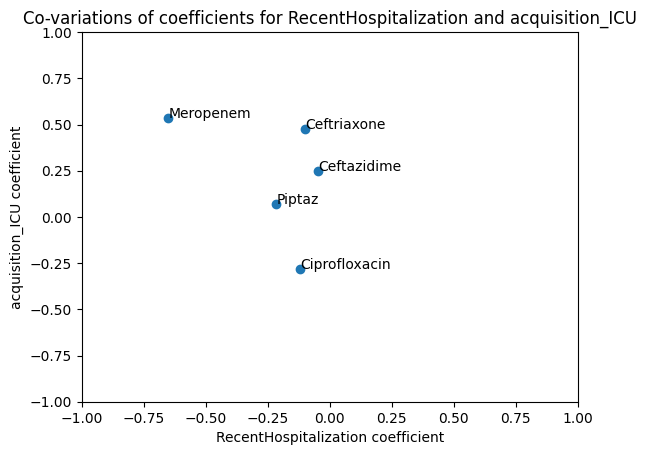

In [60]:
plt.xlabel("RecentHospitalization coefficient")
plt.ylabel("acquisition_ICU coefficient")
# plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
x=ICU_priorHosp_coeffs['RecentHospitalization']
y=ICU_priorHosp_coeffs['acquisition_ICU']
plt.scatter(x,y)
plt.title("Co-variations of coefficients for RecentHospitalization and acquisition_ICU")
for i, txt in enumerate(ICU_priorHosp_coeffs.index):
    plt.annotate(txt, (x[i], y[i]))
plt.show()